In [8]:
import numpy as np
import SimPEG.PF as PF
import dask as dd
import scipy.constants as constants
from SimPEG import Problem
from SimPEG import Utils
from SimPEG import Props
from SimPEG.Utils import mkvc
import scipy.sparse as sp
import os
import dask.array as da
from dask.distributed import Client
from sparse import COO
import dask
import multiprocessing
import time
from scipy.sparse import csr_matrix as csr


In [7]:
client = Client()
client

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:58334 remote=tcp://127.0.0.1:58264>


<Client: scheduler='tcp://127.0.0.1:58350' processes=8 cores=8>

In [6]:
client.close()


In [4]:

# Create random problem class

N = 5000
nTile = 32
nCpu = 4
import random
random.seed(1)


chunkSize = int(N/4)
class forward(object):

    A = None

    @property
    def A(self):

        if getattr(self, '_A', None) is None:

            self._A = da.random.random_sample(size=(N,N), chunks=[chunkSize,chunkSize])

        return self._A

    def fields(self, model):
        print("fields")
        return da.dot(self.A, model)

    def Jvec(self, v):
        
        m = sp.eye(N)*v
        vec = da.dot(self.A, m)
        row = dask.delayed(
            sp.csr_matrix.dot)(
                sp.eye(N), vec
            )

        return da.from_delayed(row, dtype=float, shape=[N])
    
    def Jtvec(self, v):

        vec = da.dot(self.A, v)
        row = dask.delayed(
            csr.dot)(
                sp.eye(N), vec
            )
        
#         row2 = dask.delayed(
#             csr.dot)(
#                 sp.eye(N), row
#             )

        return da.from_delayed(row, dtype=float, shape=[N])

    def JtJvec(self, v):

        vec = da.dot(self.A, v)
        
        row = dask.delayed(
            csr.dot)(
                sp.eye(N), vec
            )
        
#         row2 = dask.delayed(
#             csr.dot)(
#                 sp.eye(N), row
#             )
        
        jvec = da.from_delayed(row2, dtype=float, shape=([N]))
        
        jtjvec = da.dot(self.A, jvec)
        
        return jtjvec #da.from_delayed(jtjvec, dtype=float, shape=(1, N))

    
    def deriv(self, m):
        
#         f = self.fields(m)

        row = self.Jvec(np.ones(N))

        return da.from_delayed(row, dtype=float, shape=(1, N))

@dask.delayed
def rowSum(arr):
    sumIt = 0
    for i in range(len(arr)):
        sumIt += arr[i]
    return sumIt


# Create a list of forward
F = [forward() for ii in range(nTile)]    
        
        
    



In [6]:
%%time

deriv = []
for f in F:
    
    jvec = f.Jvec(np.ones(N))
    jtjvec = f.Jtvec(jvec)
#     jtjvec = f.JtJvec(np.ones(N))
    
    
    deriv += [jtjvec]

    
    
aa = da.vstack(deriv)

# aa = da.vstack(deriv)
total = da.sum(aa, axis=0).compute()
print(aa)


dask.array<concatenate, shape=(32, 5000), dtype=float64, chunksize=(1, 5000)>
Wall time: 1min 10s


In [10]:
%%time

fields = np.zeros(N)
tc = time.time()
for f in F:
    
    fields += f.Jvec(f.Jtvec(np.ones(N)).compute()).compute()

print(fields)
print("Run 1 in: ", time.time()-tc)


[5.00097624e+08 5.00012661e+08 4.99159258e+08 ... 4.99479921e+08
 4.99394967e+08 5.00423394e+08]
Run 1 in:  39.98299551010132
Wall time: 40 s


In [2]:
# Create functions for Dask
def calcTrow(Xn,Yn,Zn,xyzLoc, rxType='z'):
    """
    Load in the active nodes of a tensor mesh and computes the gravity tensor
    for a given observation location xyzLoc[obsx, obsy, obsz]

    INPUT:
    Xn, Yn, Zn: Node location matrix for the lower and upper most corners of
                all cells in the mesh shape[nC,2]
    M
    OUTPUT:
    Tx = [Txx Txy Txz]
    Ty = [Tyx Tyy Tyz]
    Tz = [Tzx Tzy Tzz]

    where each elements have dimension 1-by-nC.
    Only the upper half 5 elements have to be computed since symetric.
    Currently done as for-loops but will eventually be changed to vector
    indexing, once the topography has been figured out.

    """

    NewtG = constants.G*1e+8  # Convertion from mGal (1e-5) and g/cc (1e-3)
    eps = 1e-8  # add a small value to the locations to avoid

    # Pre-allocate space for 1D array
    row = np.zeros((1, Xn.shape[0]))

    dz = xyzLoc[2] - Zn

    dy = Yn - xyzLoc[1]

    dx = Xn - xyzLoc[0]

    # Compute contribution from each corners
    for aa in range(2):
        for bb in range(2):
            for cc in range(2):

                r = (
                        mkvc(dx[:, aa]) ** 2 +
                        mkvc(dy[:, bb]) ** 2 +
                        mkvc(dz[:, cc]) ** 2
                    ) ** (0.50)

                if rxType == 'x':
                    row = row - NewtG * (-1) ** aa * (-1) ** bb * (-1) ** cc * (
                        dy[:, bb] * np.log(dz[:, cc] + r + eps) +
                        dz[:, cc] * np.log(dy[:, bb] + r + eps) -
                        dx[:, aa] * np.arctan(dy[:, bb] * dz[:, cc] /
                                              (dx[:, aa] * r + eps)))

                elif rxType == 'y':
                    row = row - NewtG * (-1) ** aa * (-1) ** bb * (-1) ** cc * (
                        dx[:, aa] * np.log(dz[:, cc] + r + eps) +
                        dz[:, cc] * np.log(dx[:, aa] + r + eps) -
                        dy[:, bb] * np.arctan(dx[:, aa] * dz[:, cc] /
                                              (dy[:, bb] * r + eps)))

                else:
                    row -= NewtG * (-1) ** aa * (-1) ** bb * (-1) ** cc * (
                        dx[:, aa] * np.log(dy[:, bb] + r + eps) +
                        dy[:, bb] * np.log(dx[:, aa] + r + eps) -
                        dz[:, cc] * np.arctan(dx[:, aa] * dy[:, bb] /
                                              (dz[:, cc] * r + eps)))

    return row

                        


# Create random problem class

N = 10000

class forward(object):

    A = None

    @property
    def A(self):

        if getattr(self, '_A', None) is None:

            self._A = da.random.random_sample(size=(N,N), chunks=[int(N/16),int(N/16)])

        return self._A

    def fields(self, model):
        print("fields")
        return da.dot(self.A, model)

    def Jvec(self, v):

        vec = da.dot(self.A, v)
        row = dask.delayed(
            sp.csr_matrix.dot)(
                sp.eye(N), vec
            )

        return da.from_delayed(row, dtype=float, shape=(1, N))
    
    def Jtvec(self, v):

        vec = da.dot(self.A, v)
        row = dask.delayed(
            sp.csr_matrix.dot)(
                sp.eye(N), vec
            )

        return da.from_delayed(row, dtype=float, shape=(1, N))

    def deriv(self, m):
        
#         f = self.fields(m)

        row = self.Jvec(np.ones(N))

        return da.from_delayed(row, dtype=float, shape=(1, N))

@dask.delayed
def rowSum(arr):
    sum = 0
    for i in range(len(arr)):
        sum += arr[i]
    return sum


# Create a list of forward
F = [forward() for ii in range(10)]    
        
        
    



In [31]:
aa = da.from_delayed(row, dtype=float, shape=(1,N))
bb = da.reshape(aa, (1,N))
bb.compute().shape






NameError: name 'row' is not defined

In [ ]:
# Create functions for Dask
def calcTrow(Xn,Yn,Zn,xyzLoc, rxType='z'):
    """
    Load in the active nodes of a tensor mesh and computes the gravity tensor
    for a given observation location xyzLoc[obsx, obsy, obsz]

    INPUT:
    Xn, Yn, Zn: Node location matrix for the lower and upper most corners of
                all cells in the mesh shape[nC,2]
    M
    OUTPUT:
    Tx = [Txx Txy Txz]
    Ty = [Tyx Tyy Tyz]
    Tz = [Tzx Tzy Tzz]

    where each elements have dimension 1-by-nC.
    Only the upper half 5 elements have to be computed since symetric.
    Currently done as for-loops but will eventually be changed to vector
    indexing, once the topography has been figured out.

    """

    NewtG = constants.G*1e+8  # Convertion from mGal (1e-5) and g/cc (1e-3)
    eps = 1e-8  # add a small value to the locations to avoid

    # Pre-allocate space for 1D array
    row = np.zeros((1, Xn.shape[0]))

    dz = xyzLoc[2] - Zn

    dy = Yn - xyzLoc[1]

    dx = Xn - xyzLoc[0]

    # Compute contribution from each corners
    for aa in range(2):
        for bb in range(2):
            for cc in range(2):

                r = (
                        mkvc(dx[:, aa]) ** 2 +
                        mkvc(dy[:, bb]) ** 2 +
                        mkvc(dz[:, cc]) ** 2
                    ) ** (0.50)

                if rxType == 'x':
                    row = row - NewtG * (-1) ** aa * (-1) ** bb * (-1) ** cc * (
                        dy[:, bb] * np.log(dz[:, cc] + r + eps) +
                        dz[:, cc] * np.log(dy[:, bb] + r + eps) -
                        dx[:, aa] * np.arctan(dy[:, bb] * dz[:, cc] /
                                              (dx[:, aa] * r + eps)))

                elif rxType == 'y':
                    row = row - NewtG * (-1) ** aa * (-1) ** bb * (-1) ** cc * (
                        dx[:, aa] * np.log(dz[:, cc] + r + eps) +
                        dz[:, cc] * np.log(dx[:, aa] + r + eps) -
                        dy[:, bb] * np.arctan(dx[:, aa] * dz[:, cc] /
                                              (dy[:, bb] * r + eps)))

                else:
                    row -= NewtG * (-1) ** aa * (-1) ** bb * (-1) ** cc * (
                        dx[:, aa] * np.log(dy[:, bb] + r + eps) +
                        dy[:, bb] * np.log(dx[:, aa] + r + eps) -
                        dz[:, cc] * np.arctan(dx[:, aa] * dy[:, bb] /
                                              (dz[:, cc] * r + eps)))

    return row

                        


Creating Global Octree
Writing global Octree to fileC:\Users\DominiqueFournier\Desktop\Workspace\Paolo\SimPEG_GRAV_TileInv\OctreeMeshGlobal.msh
Tiling:0
410.0 132406.0 0.43429168 410.0


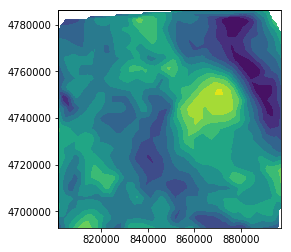

Tile 1 of 1
132406
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
4.0 4.0 103 24814 0.327147776 1.0
Saving G to zarr: C:\Users\DominiqueFournier\Desktop\Workspace\Paolo\SimPEG_GRAV_TileInv\Tile0.zarr
Use Simple


C:\Users\DominiqueFournier\Anaconda3\lib\site-packages\distributed\worker.py:2788: UserWarning: Large object of size 3.18 MB detected in task graph: 
  ([array([3.05942371e-01, 6.10496779e-02, 2.4545353 ... 717587e-04])],)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))


SimPEG.SaveModelEveryIteration will save your models in UBC format as: '###-C:\Users\DominiqueFournier\Desktop\Workspace\Paolo\SimPEG_GRAV_TileInv\\GRAV_Tile.mod'
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.06e+06  7.09e+03  2.52e-06  7.09e+03    1.91e+03      0              
Start CG solve
CG solve time: 31.726284503936768
   1  5.29e+05  4.80e+03  8.88e-04  5.27e+03    1.14e+03      0              
Start CG solve


KeyboardInterrupt: 

In [4]:
from SimPEG import Mesh, Directives, Maps, InvProblem, Optimization, Utils
from SimPEG import DataMisfit, Inversion, Regularization, mkvc
import SimPEG.PF as PF
import pylab as plt
import os
import numpy as np
from matplotlib.patches import Rectangle
from SimPEG.ObjectiveFunction import ComboObjectiveFunction
from scipy.spatial import cKDTree


work_dir = "C:\\Users\\DominiqueFournier\\Desktop\\Workspace\\Paolo"
# work_dir = "C:\\Users\\DominiqueFournier\\Dropbox\\Projects\\Synthetic\\Nut_Cracker\\"
inpFile = 'SimPEG_GRAV.inp'
out_dir = "SimPEG_GRAV_TileInv\\"
dsep = os.path.sep

padLen = 100  # Padding distance around data extent
distMax = 200  # Max discretization distance from data
maxRAM = 1.
n_cpu = 4

octreeObs = [3, 5, 1]  # Octree levels below observation points
octreeTopo = [0, 1]
ndv = -100
meshType = 'TREE'
tileProblem = True
os.system('mkdir ' + work_dir + dsep + out_dir)
parallization = "dask" # "dask" ||  "multiprocessing"

#%% User input
# Plotting parameter
#%%
# Read input file
#[mshfile, obsfile, topofile, mstart, mref, wgtfile, chi, alphas, bounds, lpnorms] = PF.Gravity.read_GRAVinv_inp(work_dir + dsep + inpFile)
driver = PF.GravityDriver.GravityDriver_Inv(work_dir + dsep + inpFile)
meshInput = driver.mesh
survey = driver.survey
topo = driver.topo
rxLoc = survey.srcField.rxList[0].locs

# Create an interpolation tree to the tensor mesh
tree = cKDTree(meshInput.gridCC)

h = np.r_[meshInput.hx.min(), meshInput.hy.min(), meshInput.hz.min()]

# LOOP THROUGH TILES
surveyMask = np.ones(survey.nD, dtype='bool')
# Going through all problems:
# 1- Pair the survey and problem
# 2- Add up sensitivity weights
# 3- Add to the ComboMisfit

# Create first mesh outside the parallel process
padDist = np.r_[
    np.c_[padLen, padLen],
    np.c_[padLen, padLen],
    np.c_[padLen, 0]
]

if meshType != meshInput._meshType:
    print("Creating Global Octree")
    mesh = Utils.modelutils.meshBuilder(
            rxLoc, h, padDist, meshType='TREE', meshGlobal=meshInput,
            verticalAlignment='center'
        )

    if topo is not None:
        mesh = Utils.modelutils.refineTree(
            mesh, topo, dtype='surface',
            nCpad=octreeTopo, finalize=False
        )

    mesh = Utils.modelutils.refineTree(
        mesh, rxLoc, dtype='surface',
        nCpad=octreeObs, finalize=True, distMax=distMax
    )

    if topo is not None:
        actv = Utils.surface2ind_topo(mesh, topo)
    else:
        actv = np.zeros(mesh.nC, dtype='bool')
        print(meshInput.vectorNz[-1])
        actv[mesh.gridCC[:, 2] < meshInput.vectorNz[-1]] = True

    if isinstance(driver.mstart, float):
        m0 = np.ones(mesh.nC) * driver.mstart

    else:
        print("Interpolating the starting model")

        _, ind = tree.query(mesh.gridCC)

        m0 = driver.m0
        m0[m0 == ndv] = 0
        m0 = m0[ind]

    if isinstance(driver._mrefInput, float):
        mref = np.ones(mesh.nC) * driver._mrefInput

    else:
        print("Interpolating the reference model")
        _, ind = tree.query(mesh.gridCC)

        mref = driver.mref
        mref[mref == ndv] = 0
        mref = mref[ind]

    print("Writing global Octree to file" + work_dir + dsep + out_dir + 'OctreeMeshGlobal.msh')
    Mesh.TreeMesh.writeUBC(
          mesh, work_dir + dsep + out_dir + 'OctreeMeshGlobal.msh',
          models={work_dir + dsep + out_dir + 'ActiveGlobal.act': actv}
        )

else:
    mesh = meshInput
    actv = np.zeros(mesh.nC, dtype='bool')
    actv[driver.activeCells] = True
    actvMap = Maps.InjectActiveCells(mesh, actv, 0)

    m0 = driver.m0  # Starting model
    mref = driver.mref  # Starting model

wrGlobal = np.zeros(int(actv.sum()))
if tileProblem:


    # Loop over different tile size and break problem until memory usage is preserved
    usedRAM = np.inf
    count = 0
    while usedRAM > maxRAM:
        print("Tiling:" + str(count))

        tiles, binCount = Utils.modelutils.tileSurveyPoints(rxLoc, count)

        # Grab the smallest bin and generate a temporary mesh
        indMin = np.argmin(binCount)

        X1, Y1 = tiles[0][:, 0], tiles[0][:, 1]
        X2, Y2 = tiles[1][:, 0], tiles[1][:, 1]

        ind_t = np.all([rxLoc[:, 0] >= tiles[0][indMin, 0], rxLoc[:, 0] <= tiles[1][indMin, 0],
                        rxLoc[:, 1] >= tiles[0][indMin, 1], rxLoc[:, 1] <= tiles[1][indMin, 1],
                        surveyMask], axis=0)

        # Create the mesh and refine the same as the global mesh
        meshLocal = Utils.modelutils.meshBuilder(
            rxLoc, h, padDist, meshType='TREE', meshGlobal=meshInput,
            verticalAlignment='center'
        )

        if topo is not None:
            meshLocal = Utils.modelutils.refineTree(
                meshLocal, topo, dtype='surface',
                nCpad=octreeTopo, finalize=False
            )

        meshLocal = Utils.modelutils.refineTree(
            meshLocal, rxLoc[ind_t, :], dtype='surface',
            nCpad=octreeObs, finalize=True, distMax=distMax
        )

        # Calculate approximate problem size
        nD, nC = ind_t.sum()*1., meshLocal.nC*1.

        nChunks = n_cpu # Number of chunks
        cSa, cSb = int(nD/nChunks), int(nC/nChunks) # Chunk sizes
        usedRAM = nD * nC * 8. * 1e-9
        count += 1
        print(nD, nC, usedRAM, binCount.min())

    nTiles = X1.shape[0]
    # Plot data and tiles
    fig, ax1 = plt.figure(), plt.subplot()
    Utils.PlotUtils.plot2Ddata(rxLoc, survey.dobs, ax=ax1)
    for ii in range(X1.shape[0]):
        ax1.add_patch(Rectangle((X1[ii], Y1[ii]),
                                X2[ii]-X1[ii],
                                Y2[ii]-Y1[ii],
                                facecolor='none', edgecolor='k'))
    ax1.set_xlim([X1.min()-20, X2.max()+20])
    ax1.set_ylim([Y1.min()-20, Y2.max()+20])
    ax1.set_aspect('equal')
    plt.show()

    def createLocalProb(rxLoc, wrGlobal, lims, ind):

        # Grab the data for current tile
        ind_t = np.all([rxLoc[:, 0] >= lims[0], rxLoc[:, 0] <= lims[1],
                        rxLoc[:, 1] >= lims[2], rxLoc[:, 1] <= lims[3],
                        surveyMask], axis=0)

        # Remember selected data in case of tile overlap
        surveyMask[ind_t] = False

        # Create new survey
        rxLoc_t = PF.BaseGrav.RxObs(rxLoc[ind_t, :])
        srcField = PF.BaseGrav.SrcField([rxLoc_t])
        survey_t = PF.BaseGrav.LinearSurvey(srcField)
        survey_t.dobs = survey.dobs[ind_t]
        survey_t.std = survey.std[ind_t]
        survey_t.ind = ind_t

        meshLocal = Utils.modelutils.meshBuilder(
            rxLoc, h, padDist, meshType='TREE', meshGlobal=meshInput,
            verticalAlignment='center'
        )

        if topo is not None:
            meshLocal = Utils.modelutils.refineTree(
                meshLocal, topo, dtype='surface',
                nCpad=octreeTopo, finalize=False
            )

        # Refine the mesh around loc
        meshLocal = Utils.modelutils.refineTree(
            meshLocal, rxLoc[ind_t, :], dtype='surface',
            nCpad=octreeObs, finalize=True, distMax=distMax
        )

        actv_t = np.ones(meshLocal.nC, dtype='bool')

        Mesh.TreeMesh.writeUBC(
              meshLocal, work_dir + dsep + out_dir + 'OctreeMesh' + str(tt) + '.msh',
              models={work_dir + dsep + out_dir + 'Active' + str(tt) + '.act': actv_t}
            )

        print(meshLocal.nC)
        # Create reduced identity map
        tileMap = Maps.Tile((mesh, actv), (meshLocal, actv_t))

        actv_t = tileMap.activeLocal

        # Create the forward model operator
        prob =  PF.Gravity.GravityIntegral(
            meshLocal, rhoMap=tileMap, actInd=actv_t, 
            parallelized=parallization, maxRAM=1., 
            Jpath=work_dir + dsep + out_dir + "Tile" + str(ind) + ".zarr",
            n_cpu=np.ceil(n_cpu/nTiles))

        survey_t.pair(prob) 

        # Data misfit function
        dmis = DataMisfit.l2_DataMisfit(survey_t)
        dmis.W = 1./survey_t.std

        wrGlobal += prob.getJtJdiag(np.ones(tileMap.P.shape[1]), W=dmis.W)

        del meshLocal

        # Create combo misfit function
        return dmis, wrGlobal


    for tt in range(nTiles):

        print("Tile " + str(tt+1) + " of " + str(X1.shape[0]))

        dmis, wrGlobal = createLocalProb(rxLoc, wrGlobal, np.r_[X1[tt], X2[tt], Y1[tt], Y2[tt]], tt)

        if tt == 0:
            ComboMisfit = dmis

        else:
            ComboMisfit += dmis
else:

    # Create the forward model operator
    ## Create identity map
    nC = int(actv.sum())
    idenMap = Maps.IdentityMap(nP=nC)

    prob =  PF.Gravity.GravityIntegral(
        mesh, rhoMap=idenMap, actInd=actv, parallelized=parallization,
        Jpath=work_dir + dsep + out_dir + "Sensitivity.zarr", n_cpu=n_cpu)

    survey.pair(prob)

    # Data misfit function
    ComboMisfit = DataMisfit.l2_DataMisfit(survey)
    ComboMisfit.W = 1./survey.std

    wrGlobal += prob.getJtJdiag(np.ones(nC), W=ComboMisfit.W)
    actvGlobal = actv
# print('Sum of all problems:' + str(probSize*1e-6) + ' Mb')
# Scale global weights for regularization

# Check if global mesh has regions untouched by local problem
actvGlobal = wrGlobal != 0
if actvGlobal.sum() < actv.sum():

    if isinstance(ComboMisfit, ComboObjectiveFunction):
        for ind, dmis in enumerate(ComboMisfit.objfcts):
            dmis.prob.rhoMap.index = actvGlobal
            dmis.prob.rhoMap._P = None
            dmis.prob._model = None
            dmis.prob.gtgdiag = None
    else:
        ComboMisfit.prob.rhoMap.index = actvGlobal
        ComboMisfit.prob.rhoMap._P = None
        ComboMisfit.prob.model = np.zeros(actvGlobal.sum())
        ComboMisfit.prob.gtgdiag = None

wrGlobal = wrGlobal[actvGlobal]**0.5
wrGlobal = (wrGlobal/np.max(wrGlobal))

#%% Create a regularization
actvMap = Maps.InjectActiveCells(mesh, actv, 0)

actv = np.all([actv, actvMap*actvGlobal], axis=0)
actvMap = Maps.InjectActiveCells(mesh, actv, -100)

m0 = m0[actv]
mref = mref[actv]

idenMap = Maps.IdentityMap(nP=int(np.sum(actv)))
reg = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap)
reg.norms = np.c_[driver.lpnorms].T

if driver.eps is not None:
    reg.eps_p = driver.eps[0]
    reg.eps_q = driver.eps[1]

reg.cell_weights = wrGlobal
reg.mref = mref

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=20, lower=-10, upper=10.,
                                 maxIterLS=20, maxIterCG=20, tolCG=1e-4)
invProb = InvProblem.BaseInvProblem(ComboMisfit, reg, opt)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e0)

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
#  model parameters
IRLS = Directives.Update_IRLS(f_min_change=1e-3, minGNiter=1,
                              maxIRLSiter=10, betaSearch=False)

IRLS.target = driver.survey.nD
update_Jacobi = Directives.UpdatePreconditioner()
saveModel = Directives.SaveUBCModelEveryIteration(mapping=actvMap, fileName=work_dir + dsep + out_dir + dsep + "GRAV_Tile")
inv = Inversion.BaseInversion(invProb,
                              directiveList=[betaest, saveModel,
                                             IRLS, update_Jacobi])

# Run the inversion
mrec = inv.run(m0)

In [ ]:
from SimPEG import Mesh, Directives, Maps, InvProblem, Optimization, Utils
from SimPEG import DataMisfit, Inversion, Regularization, mkvc
import SimPEG.PF as PF
import pylab as plt
import os
import numpy as np
from matplotlib.patches import Rectangle
from SimPEG.ObjectiveFunction import ComboObjectiveFunction
from scipy.spatial import cKDTree


work_dir = "C:\\Users\\DominiqueFournier\\Dropbox\\Projects\\Synthetic\\Nut_Cracker\\"
#work_dir = "C:\\Egnyte\\Private\\dominiquef\\Projects\\4559_CuMtn_ZTEM\\Modeling\\MAG\\A1_Fenton\\"
# work_dir = 'C:\\Users\\DominiqueFournier\\Dropbox\\Projects\\Kevitsa\\Kevitsa\\Modeling\\MAG\\Airborne\\'
# work_dir = "C:\\Users\\DominiqueFournier\\ownCloud\\Research\\CraigModel\\MAG\\"
#work_dir = "C:\\Users\\DominiqueFournier\\ownCloud\\Research\\Yukon\\Modeling\\MAG\\"
#work_dir = "C:\\Users\\DominiqueFournier\\ownCloud\\Research\\Synthetic\\Triple_Block_lined\\"
#work_dir = "C:\\Users\\DominiqueFournier\\ownCloud\\Research\\TKC\\DIGHEM_TMI\\"

out_dir = "SimPEG_Susc_TileInv\\"
input_file = "SimPEG_MAG.inp"

dsep = os.path.sep


padLen = 1000
maxRAM = .01
n_cpu = 4

octreeObs = [2,0] #[5, 20, 5]  # Octree levels below observation points
octreeTopo = [0,1] #[0, 0, 3]

meshType = 'TREE'


# %%
# Read in the input file which included all parameters at once
# (mesh, topo, model, survey, inv param, etc.)
driver = PF.MagneticsDriver.MagneticsDriver_Inv(work_dir + input_file)

os.system('if not exist ' + work_dir + out_dir + ' mkdir ' + work_dir+out_dir)

# Access the mesh and survey information
meshInput = driver.mesh
survey = driver.survey
rxLoc = survey.srcField.rxList[0].locs

topo = None
if driver.topofile is not None:
    topo = np.genfromtxt(driver.basePath + driver.topofile,
                         skip_header=1)
else:
    # Grab the top coordinate and make a flat topo
    indTop = meshInput.gridCC[:, 2] == meshInput.vectorCCz[-1]
    topo = meshInput.gridCC[indTop, :]
    topo[:, 2] += meshInput.hz.min()/2. + 1e-8

# # TILE THE PROBLEM
# Define core mesh properties
h = np.r_[meshInput.hx.min(), meshInput.hy.min(), meshInput.hz.min()]

# LOOP THROUGH TILES
surveyMask = np.ones(survey.nD, dtype='bool')
# Going through all problems:
# 1- Pair the survey and problem
# 2- Add up sensitivity weights
# 3- Add to the ComboMisfit

# Create first mesh outside the parallel process
padDist = np.r_[np.c_[padLen, padLen], np.c_[padLen, padLen], np.c_[padLen, 0]]

if meshType != meshInput._meshType:
    print("Creating Global Octree")
    mesh = Utils.modelutils.meshBuilder(
            rxLoc, h, padDist, meshType='TREE', meshGlobal=meshInput,
            verticalAlignment='center'
        )

    if topo is not None:
        mesh = Utils.modelutils.refineTree(
            mesh, topo, dtype='surface',
            nCpad=octreeTopo, finalize=False
        )

    mesh = Utils.modelutils.refineTree(
        mesh, rxLoc, dtype='surface',
        nCpad=octreeObs, finalize=True
    )

    if topo is not None:
        actv = Utils.surface2ind_topo(mesh, topo)
    else:
        actv = np.zeros(mesh.nC, dtype='bool')
        print(meshInput.vectorNz[-1])
        actv[mesh.gridCC[:, 2] < meshInput.vectorNz[-1]] = True

    m0 = np.ones(actv.sum()) * 1e-4

    print("Writing global Octree to file" + work_dir + out_dir + 'OctreeMeshGlobal.msh')
    Mesh.TreeMesh.writeUBC(
          mesh, work_dir + out_dir + 'OctreeMeshGlobal.msh',
          models={work_dir + out_dir + 'ActiveGlobal.act': actv}
        )


else:
    mesh = meshInput
    actv = np.zeros(mesh.nC, dtype='bool')
    actv[driver.activeCells] = True
    m0 = driver.m0  # Starting model


wrGlobal = np.zeros(int(actv.sum()))
actvMap = Maps.InjectActiveCells(mesh, actv, 1e-8)
# Loop over different tile size and break problem until memory usage is preserved
usedRAM = np.inf
count = 0
while usedRAM > maxRAM:
    print("Tiling:" + str(count))

    tiles, binCount = Utils.modelutils.tileSurveyPoints(rxLoc, count)

    # Grab the smallest bin and generate a temporary mesh
    indMin = np.argmin(binCount)

    X1, Y1 = tiles[0][:, 0], tiles[0][:, 1]
    X2, Y2 = tiles[1][:, 0], tiles[1][:, 1]

    ind_t = np.all([rxLoc[:, 0] >= tiles[0][indMin, 0], rxLoc[:, 0] <= tiles[1][indMin, 0],
                    rxLoc[:, 1] >= tiles[0][indMin, 1], rxLoc[:, 1] <= tiles[1][indMin, 1],
                    surveyMask], axis=0)
    meshLocal = Utils.modelutils.meshBuilder(
        rxLoc, h, padDist, meshType='TREE', meshGlobal=meshInput,
        verticalAlignment='center'
    )

    if topo is not None:
        meshLocal = Utils.modelutils.refineTree(
            meshLocal, topo, dtype='surface',
            nCpad=octreeTopo, finalize=False
        )

    meshLocal = Utils.modelutils.refineTree(
        meshLocal, rxLoc[ind_t, :], dtype='surface',
        nCpad=octreeObs, finalize=True
    )

    nD, nC = ind_t.sum()*1., meshLocal.nC*1.

    nChunks = n_cpu # Number of chunks
    cSa, cSb = int(nD/nChunks), int(nC/nChunks) # Chunk sizes
    usedRAM = nD * nC * 8. * 1e-9
    count += 1
    print(nD, nC, usedRAM)

# Plot data and tiles
fig, ax1 = plt.figure(), plt.subplot()
Utils.PlotUtils.plot2Ddata(rxLoc, survey.dobs, ax=ax1)
for ii in range(X1.shape[0]):
    ax1.add_patch(Rectangle((X1[ii], Y1[ii]),
                            X2[ii]-X1[ii],
                            Y2[ii]-Y1[ii],
                            facecolor='none', edgecolor='k'))
ax1.set_xlim([X1.min()-20, X2.max()+20])
ax1.set_ylim([Y1.min()-20, Y2.max()+20])
ax1.set_aspect('equal')
plt.show()


def createLocalProb(rxLoc, wrGlobal, lims, ind):

    # Grab the data for current tile
    ind_t = np.all([rxLoc[:, 0] >= lims[0], rxLoc[:, 0] <= lims[1],
                    rxLoc[:, 1] >= lims[2], rxLoc[:, 1] <= lims[3],
                    surveyMask], axis=0)

    # Remember selected data in case of tile overlap
    surveyMask[ind_t] = False

    # Create new survey
    rxLoc_t = PF.BaseMag.RxObs(rxLoc[ind_t, :])
    srcField = PF.BaseMag.SrcField([rxLoc_t], param=survey.srcField.param)
    survey_t = PF.BaseMag.LinearSurvey(srcField)
    survey_t.dobs = survey.dobs[ind_t]
    survey_t.std = survey.std[ind_t]
    survey_t.ind = ind_t

    meshLocal = Utils.modelutils.meshBuilder(
        rxLoc, h, padDist, meshType='TREE', meshGlobal=meshInput,
        verticalAlignment='center'
    )

    if topo is not None:
        meshLocal = Utils.modelutils.refineTree(
            meshLocal, topo, dtype='surface',
            nCpad=octreeTopo, finalize=False
        )

    # Refine the mesh around loc
    meshLocal = Utils.modelutils.refineTree(
        meshLocal, rxLoc[ind_t, :], dtype='surface',
        nCpad=octreeObs, finalize=True
    )

    actv_t = np.ones(meshLocal.nC, dtype='bool')

    # Create reduced identity map
    tileMap = Maps.Tile((mesh, actv), (meshLocal, actv_t))

    actv_t = tileMap.activeLocal

    print(actv_t.sum(), meshLocal.nC)
    # Create the forward model operator
    prob = PF.Magnetics.MagneticIntegral(
        meshLocal, chiMap=tileMap, actInd=actv_t, parallelized='dask',
        Jpath=work_dir + out_dir + "Tile" + str(ind) + ".zarr",
        n_cpu=n_cpu)

    survey_t.pair(prob)

    # Data misfit function
    dmis = DataMisfit.l2_DataMisfit(survey_t)
    dmis.W = 1./survey_t.std

    wr = prob.getJtJdiag(np.ones(tileMap.P.shape[1]), W=dmis.W)
    localMap = Maps.InjectActiveCells(meshLocal, actv_t, 1e-8)
    Mesh.TreeMesh.writeUBC(
                      mesh, work_dir + out_dir + 'OctreeMesh' + str(tt) + '.msh',
                      models={work_dir + out_dir + 'Wr_' + str(tt) + '.act': actvMap * wr}
                    )

    Mesh.TreeMesh.writeUBC(
                      meshLocal, work_dir + out_dir + 'OctreeMesh' + str(tt) + '.msh',
                      models={work_dir + out_dir + 'Wr_' + str(tt) + '.act': localMap * tileMap * wr}
                    )
#    localMap = Maps.InjectActiveCells(meshLocal, actv_t, 1e-8)
#    Mesh.TreeMesh.writeUBC(
#                      meshLocal, work_dir + out_dir + 'OctreeMesh' + str(tt) + '.msh',
#                      models={work_dir + out_dir + 'Wr_' + str(tt) + '.act': localMap*wr}
#                    )
#
    wrGlobal += wr

    del meshLocal


    # Create combo misfit function
    return dmis, wrGlobal


for tt in range(X1.shape[0]):

    print("Tile " + str(tt+1) + " of " + str(X1.shape[0]))

    dmis, wrGlobal = createLocalProb(rxLoc, wrGlobal, np.r_[X1[tt], X2[tt], Y1[tt], Y2[tt]], tt)

    if tt == 0:
        ComboMisfit = dmis

    else:
        ComboMisfit += dmis

# print('Sum of all problems:' + str(probSize*1e-6) + ' Mb')
# Scale global weights for regularization

# Check if global mesh has regions untouched by local problem
actvGlobal = wrGlobal != 0
if actvGlobal.sum() < actv.sum():

    for ind, dmis in enumerate(ComboMisfit.objfcts):
        dmis.prob.chiMap.index = actvGlobal

wrGlobal = wrGlobal[actvGlobal]**0.5
wrGlobal = (wrGlobal/np.max(wrGlobal))



#%% Create a regularization
actvMap = Maps.InjectActiveCells(mesh, actv, 0)
actv = np.all([actv, actvMap*actvGlobal], axis=0)
actvMap = Maps.InjectActiveCells(mesh, actv, 1e-8)
idenMap = Maps.IdentityMap(nP=int(np.sum(actv)))

Mesh.TreeMesh.writeUBC(
          mesh, work_dir + out_dir + 'OctreeMeshGlobal.msh',
          models={work_dir + out_dir + 'SensWeights.mod': actvMap * wrGlobal}
        )


reg = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap)
reg.norms = np.c_[driver.lpnorms].T
reg.cell_weights = wrGlobal
reg.mref = np.ones(mesh.nC)[actv] * np.mean(driver.mref)

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=30, lower=0., upper=10.,
                                 maxIterLS=20, maxIterCG=20, tolCG=1e-4)
invProb = InvProblem.BaseInvProblem(ComboMisfit, reg, opt)
betaest = Directives.BetaEstimate_ByEig()

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
#  model parameters
IRLS = Directives.Update_IRLS(f_min_change=1e-3, minGNiter=1,
                              maxIRLSiter=10)

IRLS.target = driver.survey.nD
update_Jacobi = Directives.UpdatePreconditioner()
saveModel = Directives.SaveUBCModelEveryIteration(mapping=actvMap, fileName=work_dir + out_dir + "MAG_Tile")
inv = Inversion.BaseInversion(invProb,
                              directiveList=[betaest, saveModel,
                                             IRLS, update_Jacobi])

# Run the inversion
mrec = inv.run(m0)

Creating Global Octree
Writing global Octree to fileC:\Users\DominiqueFournier\Dropbox\Projects\Synthetic\Nut_Cracker\SimPEG_Susc_TileInv\OctreeMeshGlobal.msh
Tiling:0
342.0 4712.0 0.012892032000000001
Tiling:1
171.0 3480.0 0.00476064


<Figure size 640x480 with 1 Axes>

Tile 1 of 2
1376 3480
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
Begin forward: M=H0, Rx type= tmi
Dask: 4 4 42 344 0.00046233600000000004 8
Load G from zarr
Tile 2 of 2
1341 3445
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
Begin forward: M=H0, Rx type= tmi
Dask: 4 4 42 335 0.00045024 8
Load G from zarr
Use Simple


Creating Global Octree
Writing global Octree to fileC:\Users\DominiqueFournier\Downloads\TestShawn\UBC_rem\SimPEG_MVI_S_TileInv\OctreeMeshGlobal.msh
Tiling:0
1219.0 31095.0 0.90971532 1219.0


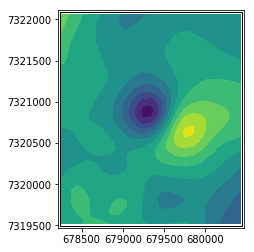

Tile 1 of 1
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
Begin forward: M=full, Rx type= tmi
Dask: 4.0 4.0 305 19445 0.7591328 1.0
Saving G to zarr: C:\Users\DominiqueFournier\Downloads\TestShawn\UBC_rem\SimPEG_MVI_S_TileInv\Tile0.zarr


KeyboardInterrupt: 

In [4]:
from SimPEG import Mesh, Directives, Maps, InvProblem, Optimization, Utils
from SimPEG import DataMisfit, Inversion, Regularization, mkvc
import SimPEG.PF as PF
import pylab as plt
import os
import numpy as np
from matplotlib.patches import Rectangle
from SimPEG.ObjectiveFunction import ComboObjectiveFunction
from scipy.spatial import cKDTree


work_dir = "C:\\Users\\DominiqueFournier\\Downloads\\TestShawn\\UBC_rem\\"

out_dir = "SimPEG_MVI_S_TileInv\\"
input_file = "SimPEG_MAG.inp"

dsep = os.path.sep


padLen = 500  # Padding distance around the convex haul of the data
maxRAM = 1.  # Maximum memory size allowed for each tiles
n_cpu = 4     # Number of processors allocated
distMax = 200  # Max discretization distance from data

octreeObs = [3, 10, 10]  # Octree levels below data points [n1*dz, n2*dz**2, ...]
octreeTopo = [0, 0 ,1]   # Octree levels below topography [n1*dz, n2*dz**2, ...]

meshType = 'TREE'   # Inversion mesh type
tileProblem = True  # Tile the forward True | False
parallelized = "dask"  #"multiprocessing" # "dask" ||  "multiprocessing"
###############################################################################
# Inversion script starts here
# ----------------------------
# Read in the input file which included all parameters at once
# (mesh, topo, model, survey, inv param, etc.)
#

os.system('if not exist ' + work_dir + dsep + out_dir + dsep + ' mkdir ' + work_dir+out_dir)
driver = PF.MagneticsDriver.MagneticsDriver_Inv(work_dir + input_file)

# Access the mesh and survey information
meshInput = driver.mesh
survey = driver.survey
rxLoc = survey.srcField.rxList[0].locs

topo = None
if driver.topofile is not None:
    topo = np.genfromtxt(driver.basePath + driver.topofile,
                         skip_header=1)
else:
    # Grab the top coordinate of mesh and make a flat topo
    indTop = meshInput.gridCC[:, 2] == meshInput.vectorCCz[-1]
    topo = meshInput.gridCC[indTop, :]
    topo[:, 2] += meshInput.hz.min()/2. + 1e-8

# Remember selected data in case of tile overlap
surveyMask = np.ones(survey.nD, dtype='bool')

# Define the octree mesh based on the provided tensor
h = np.r_[meshInput.hx.min(), meshInput.hy.min(), meshInput.hz.min()]
padDist = np.r_[np.c_[padLen, padLen], np.c_[padLen, padLen], np.c_[padLen, 0]]

if meshType != meshInput._meshType:
    print("Creating Global Octree")
    mesh = Utils.modelutils.meshBuilder(
            rxLoc, h, padDist, meshType='TREE', meshGlobal=meshInput,
            verticalAlignment='center'
        )

    # Refine the octree mesh below topography
    if topo is not None:
        mesh = Utils.modelutils.refineTree(
            mesh, topo, dtype='surface',
            nCpad=octreeTopo, finalize=False
        )

    # Refine the octree mesh around the obs and finalize
    mesh = Utils.modelutils.refineTree(
        mesh, rxLoc, dtype='surface',
        nCpad=octreeObs, finalize=True, distMax=distMax
    )

    # Compute active cells
    if topo is not None:
        actv = Utils.surface2ind_topo(mesh, topo)
    else:
        actv = np.zeros(mesh.nC, dtype='bool')
        print(meshInput.vectorNz[-1])
        actv[mesh.gridCC[:, 2] < meshInput.vectorNz[-1]] = True

    print("Writing global Octree to file" + work_dir + out_dir + 'OctreeMeshGlobal.msh')
    Mesh.TreeMesh.writeUBC(
          mesh, work_dir + out_dir + 'OctreeMeshGlobal.msh',
          models={work_dir + out_dir + 'ActiveGlobal.act': actv}
        )


else:
    mesh = meshInput
    actv = np.zeros(mesh.nC, dtype='bool')
    actv[driver.activeCells] = True


actvMap = Maps.InjectActiveCells(mesh, actv, 0)
wrGlobal = np.zeros(int(actv.sum()*3))


if tileProblem:

    # Loop over different tile size and break problem until
    # memory footprint false below maxRAM
    usedRAM = np.inf
    count = 0
    while usedRAM > maxRAM:
        print("Tiling:" + str(count))

        tiles, binCount = Utils.modelutils.tileSurveyPoints(rxLoc, count)

        # Grab the smallest bin and generate a temporary mesh
        indMin = np.argmin(binCount)

        X1, Y1 = tiles[0][:, 0], tiles[0][:, 1]
        X2, Y2 = tiles[1][:, 0], tiles[1][:, 1]

        ind_t = np.all([rxLoc[:, 0] >= tiles[0][indMin, 0], rxLoc[:, 0] <= tiles[1][indMin, 0],
                        rxLoc[:, 1] >= tiles[0][indMin, 1], rxLoc[:, 1] <= tiles[1][indMin, 1],
                        surveyMask], axis=0)

        # Create the mesh and refine the same as the global mesh
        meshLocal = Utils.modelutils.meshBuilder(
            rxLoc, h, padDist, meshType='TREE', meshGlobal=meshInput,
            verticalAlignment='center'
        )

        if topo is not None:
            meshLocal = Utils.modelutils.refineTree(
                meshLocal, topo, dtype='surface',
                nCpad=octreeTopo, finalize=False
            )

        meshLocal = Utils.modelutils.refineTree(
            meshLocal, rxLoc[ind_t, :], dtype='surface',
            nCpad=octreeObs, finalize=True, distMax=distMax
        )

        # Calculate approximate problem size
        nD, nC = ind_t.sum()*1., meshLocal.nC*1.

        nChunks = n_cpu # Number of chunks
        cSa, cSb = int(nD/nChunks), int(nC/nChunks) # Chunk sizes
        usedRAM = nD * nC * 8. * 1e-9 * 3
        count += 1
        print(nD, nC, usedRAM, binCount.min())

    # After tiling:
    # Plot data and tiles
    fig, ax1 = plt.figure(), plt.subplot()
    Utils.PlotUtils.plot2Ddata(rxLoc, survey.dobs, ax=ax1)
    for ii in range(X1.shape[0]):
        ax1.add_patch(Rectangle((X1[ii], Y1[ii]),
                                X2[ii]-X1[ii],
                                Y2[ii]-Y1[ii],
                                facecolor='none', edgecolor='k'))
    ax1.set_xlim([X1.min()-20, X2.max()+20])
    ax1.set_ylim([Y1.min()-20, Y2.max()+20])
    ax1.set_aspect('equal')
    plt.show()

    nTiles = X1.shape[0]

    def createLocalProb(rxLoc, wrGlobal, lims, ind):
        # createLocalProb(rxLoc, wrGlobal, lims, ind)
        # Generate a problem, calculate/store sensitivities for
        # given data points

        # Grab the data for current tile
        ind_t = np.all([rxLoc[:, 0] >= lims[0], rxLoc[:, 0] <= lims[1],
                        rxLoc[:, 1] >= lims[2], rxLoc[:, 1] <= lims[3],
                        surveyMask], axis=0)

        # Remember selected data in case of tile overlap
        surveyMask[ind_t] = False

        # Create new survey
        rxLoc_t = PF.BaseMag.RxObs(rxLoc[ind_t, :])
        srcField = PF.BaseMag.SrcField([rxLoc_t], param=survey.srcField.param)
        survey_t = PF.BaseMag.LinearSurvey(srcField)
        survey_t.dobs = survey.dobs[ind_t]
        survey_t.std = survey.std[ind_t]
        survey_t.ind = ind_t

        meshLocal = Utils.modelutils.meshBuilder(
            rxLoc, h, padDist, meshType='TREE', meshGlobal=meshInput,
            verticalAlignment='center'
        )

        if topo is not None:
            meshLocal = Utils.modelutils.refineTree(
                meshLocal, topo, dtype='surface',
                nCpad=octreeTopo, finalize=False
            )

        # Refine the mesh around loc
        meshLocal = Utils.modelutils.refineTree(
            meshLocal, rxLoc[ind_t, :], dtype='surface',
            nCpad=octreeObs, finalize=True, distMax=distMax
        )

        actv_t = np.ones(meshLocal.nC, dtype='bool')

        # Create reduced identity map
        tileMap = Maps.Tile((mesh, actv), (meshLocal, actv_t), nBlock = 3)

        actv_t = tileMap.activeLocal

        # Create the forward model operator
        prob = PF.Magnetics.MagneticIntegral(
                    meshLocal, chiMap=tileMap, actInd=actv_t, parallelized=parallelized,
                    Jpath=work_dir + out_dir + "Tile" + str(ind) + ".zarr", maxRAM=maxRAM,
                    modelType='vector', n_cpu=np.ceil(n_cpu/nTiles)
        )

        survey_t.pair(prob)

        # Data misfit function
        dmis = DataMisfit.l2_DataMisfit(survey_t)
        dmis.W = 1./survey_t.std

        wr = prob.getJtJdiag(np.ones(int(tileMap.P.shape[1])), W=dmis.W)
        Mesh.TreeMesh.writeUBC(
              meshLocal, work_dir + out_dir + 'OctreeMesh' + str(tt) + '.msh',
              models={work_dir + out_dir + 'Wr_' + str(tt) + '.act': (tileMap*wr)[:meshLocal.nC]+1e-8}
            )
        wrGlobal += wr

        del meshLocal
        # Create combo misfit function
        return dmis, wrGlobal

    # Loop through the tiles and generate all sensitivities
    for tt in range(nTiles):

        print("Tile " + str(tt+1) + " of " + str(X1.shape[0]))

        dmis, wrGlobal = createLocalProb(rxLoc, wrGlobal, np.r_[X1[tt], X2[tt], Y1[tt], Y2[tt]], tt)

        # Add the problems to a Combo Objective function
        if tt == 0:
            ComboMisfit = dmis

        else:
            ComboMisfit += dmis

# If not tiled, just a single problem
else:

    # Create the forward model operator
    # Create identity map
    nC = int(actv.sum())
    idenMap = Maps.IdentityMap(nP=int(3*nC))

    prob = PF.Magnetics.MagneticIntegral(
        mesh, chiMap=idenMap, actInd=actv, parallelized=parallelized,
        Jpath=work_dir + out_dir + "Sensitivity.zarr",
        modelType='vector', n_cpu=n_cpu)

    survey.pair(prob)

    # Data misfit function
    ComboMisfit = DataMisfit.l2_DataMisfit(survey)
    ComboMisfit.W = 1./survey.std

    wrGlobal += prob.getJtJdiag(np.ones(int(3*nC)), W=ComboMisfit.W)
    actvGlobal = actv

# Scale global weights for regularization
# Check if global mesh has regions untouched by local problem
# NEED REVIEW FOR THIS CASE
# (ONLY AN ISSUE FOR TENSOR INVERSION MESH)
nC = int(actv.sum())
actvGlobal = wrGlobal != 0
actvMeshGlobal = (wrGlobal[:nC]) != 0
if actvMeshGlobal.sum() < actv.sum():

    if isinstance(ComboMisfit, ComboObjectiveFunction):
        for ind, dmis in enumerate(ComboMisfit.objfcts):
            dmis.prob.chiMap.index = actvMeshGlobal
            dmis.prob.gtgdiag = None

    else:
        ComboMisfit.prob.chiMap.index = actvGlobal
        ComboMisfit.prob.rhoMap._P = None
        ComboMisfit.prob.model = np.zeros(actvGlobal.sum())
        ComboMisfit.prob.gtgdiag = None

# Global sensitivity weights (linear)
wrGlobal = wrGlobal[actvGlobal]**0.5
wrGlobal = (wrGlobal/np.max(wrGlobal))

# Create global active set
actv = np.all([actv, actvMap*actvMeshGlobal], axis=0)
actvMap = Maps.InjectActiveCells(mesh, actv, 0)  # For re-projection
actvMapAmp = Maps.InjectActiveCells(mesh, actv, -100)  # For final output

nC = int(np.sum(actv))

mstart = np.ones(3*nC) * 1e-4

# Assumes amplitude reference, distributed on 3 components
mref = np.ones(3*nC) * (np.mean(driver.mref)**2./3)**0.5

# Create a block diagonal regularization
wires = Maps.Wires(('p', nC), ('s', nC), ('t', nC))

# Create a regularization
reg_p = Regularization.Sparse(mesh, indActive=actv, mapping=wires.p)
reg_p.cell_weights = (wires.p * wrGlobal)
reg_p.norms = np.c_[2, 2, 2, 2]
reg_p.mref = mref

reg_s = Regularization.Sparse(mesh, indActive=actv, mapping=wires.s)
reg_s.cell_weights = (wires.s * wrGlobal)
reg_s.norms = np.c_[2, 2, 2, 2]
reg_s.mref = mref

reg_t = Regularization.Sparse(mesh, indActive=actv, mapping=wires.t)
reg_t.cell_weights = (wires.t * wrGlobal)
reg_t.norms = np.c_[2, 2, 2, 2]
reg_t.mref = mref

# Assemble the 3-component regularizations
reg = reg_p + reg_s + reg_t
reg.mref = mref


opt = Optimization.ProjectedGNCG(maxIter=5, lower=-10., upper=10.,
                                 maxIterCG=20, tolCG=1e-3)

invProb = InvProblem.BaseInvProblem(ComboMisfit, reg, opt)
betaest = Directives.BetaEstimate_ByEig()

# Add directives to the inversion
# Here is where the norms are applied
IRLS = Directives.Update_IRLS(f_min_change=1e-3, maxIRLSiter=0,
                              minGNiter=1, betaSearch=False)

# Pre-conditioner
update_Jacobi = Directives.UpdatePreconditioner()

# Output models between each iteration
saveModel = Directives.SaveUBCModelEveryIteration(mapping=actvMap, vector=True)
saveModel.fileName = work_dir + out_dir + 'MVI_C'

# Put it all together
inv = Inversion.BaseInversion(invProb,
                              directiveList=[betaest, IRLS, update_Jacobi,
                                             saveModel])

# Invert
mrec_MVI = inv.run(mstart)

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Wed May  9 13:20:56 2018

@author: fourndo@gmail.com


Run an equivalent source inversion

"""
from SimPEG import (
    Mesh, Utils, Maps, Regularization, Regularization,
    DataMisfit, Inversion, InvProblem, Directives, Optimization,
    )
import SimPEG.PF as PF
import numpy as np
import os
import json
from scipy.spatial import Delaunay
from scipy.interpolate import NearestNDInterpolator
from scipy.spatial import cKDTree
from SimPEG.Utils import mkvc
import dask


workDir = ".\\"
#    workDir = "C:\\Users\DominiqueFournier\\Dropbox\\Projects\\Synthetic\\Nut_Cracker\\"
workDir = "C:\\Users\\DominiqueFournier\\Dropbox\\Projects\\Kevitsa\\Kevitsa\\Modeling\\MAG"
outDir = "EquivalentSource\\"
inputFile = "SimPEG_ES.json"

# Default parameter values
padLen = 1000
maxRAM = 1.
n_cpu = 8
n_chunks = 1
parallelized = 'dask'
octreeObs = [2, 0]  # Octree levels below observation points
octreeTopo = [0, 0, 1, 0]


h = np.r_[20, 20, 20]
meshType = 'TREE'
targetChi = 100
tileProblem = True
meshInput = None
padRatio = 2.
topo = False
ndv = -100

dsep = os.path.sep

os.system('mkdir ' + workDir + dsep + dsep + outDir)

# Read json file and overwrite defaults
with open(workDir + dsep + inputFile, 'r') as f:
    driver = json.load(f)

# Deal with the data
if driver["dataFile"][0] == 'GRAV':

    survey = Utils.io_utils.readUBCgravityObservations(workDir + dsep + driver["dataFile"][1])

elif driver["dataFile"][0] == 'MAG':

    survey, H0 = Utils.io_utils.readUBCmagneticsObservations(workDir + dsep + driver["dataFile"][1])

else:
    assert False, "Equivalent source only implemented for 'dataFile' 'GRAV' | 'MAG' "

if "mesh" in list(driver.keys()):
    meshInput = Mesh.TensorMesh.readUBC(workDir + dsep + driver["mesh"])

if "topography" in list(driver.keys()):
    topo = np.genfromtxt(workDir + dsep + driver["topography"],
                         skip_header=1)

    # Compute distance of obs above topo
    F = NearestNDInterpolator(topo[:, :2], topo[:, 2])



else:
    # Grab the top coordinate and make a flat topo
    indTop = meshInput.gridCC[:, 2] == meshInput.vectorCCz[-1]
    topo = meshInput.gridCC[indTop, :]
    topo[:, 2] += meshInput.hz.min()/2. + 1e-8


if "padRatio" in list(driver.keys()):

    padRatio = driver["padRatio"]


if "targetChi" in list(driver.keys()):
    targetChi = driver["targetChi"]


if "octreeCellSize" in list(driver.keys()):
    h = driver["octreeCellSize"]

if "tileProblem" in list(driver.keys()):
    tileProblem = driver["tileProblem"]

rxLoc = survey.srcField.rxList[0].locs

# Create near obs topo
newTopo = np.c_[rxLoc[:, :2], F(rxLoc[:,:2])]

# LOOP THROUGH TILES
surveyMask = np.ones(survey.nD, dtype='bool')
# Going through all problems:
# 1- Pair the survey and problem
# 2- Add up sensitivity weights
# 3- Add to the ComboMisfit

# Create first mesh outside the parallel process
padDist = np.r_[np.c_[padLen, padLen], np.c_[padLen, padLen], np.c_[padLen, 0]]

print("Creating Global Octree")
mesh = Utils.modelutils.meshBuilder(
        rxLoc, h, padDist, meshType='TREE', meshGlobal=meshInput,
        verticalAlignment='center'
    )

if topo is not None:
    mesh = Utils.modelutils.refineTree(
        mesh, topo, dtype='surface',
        nCpad=octreeTopo, finalize=False
    )

mesh = Utils.modelutils.refineTree(
    mesh, newTopo, dtype='surface', padRatio=padRatio,
    nCpad=octreeObs, finalize=True
)

# Compute active cells
activeCells = Utils.surface2ind_topo(mesh, topo)

#    activeCells = Utils.modelutils.activeTopoLayer(mesh, topo)

Mesh.TreeMesh.writeUBC(
      mesh, workDir + dsep + outDir + 'OctreeMeshGlobal.msh',
      models={workDir + dsep + outDir + 'ActiveSurface.act': activeCells}
    )


# Get the layer of cells directly below topo
#activeCells = Utils.actIndFull2layer(mesh, active)
nC = int(activeCells.sum())  # Number of active cells
print(nC)
# Create active map to go from reduce set to full
activeCellsMap = Maps.InjectActiveCells(mesh, activeCells, ndv)

# Create identity map
idenMap = Maps.IdentityMap(nP=nC)
wrGlobal = np.zeros(nC)

if tileProblem:

    # Loop over different tile size and break problem until
    # memory footprint false below maxRAM
    usedRAM = np.inf
    count = 8
    while usedRAM > maxRAM:
        print("Tiling:" + str(count))

        tiles, binCount = Utils.modelutils.tileSurveyPoints(rxLoc, count)

        # Grab the smallest bin and generate a temporary mesh
        indMin = np.argmin(binCount)

        X1, Y1 = tiles[0][:, 0], tiles[0][:, 1]
        X2, Y2 = tiles[1][:, 0], tiles[1][:, 1]

        ind_t = np.all([rxLoc[:, 0] >= tiles[0][indMin, 0], rxLoc[:, 0] <= tiles[1][indMin, 0],
                        rxLoc[:, 1] >= tiles[0][indMin, 1], rxLoc[:, 1] <= tiles[1][indMin, 1],
                        surveyMask], axis=0)

        # Create the mesh and refine the same as the global mesh
        meshLocal = Utils.modelutils.meshBuilder(
                rxLoc, h, padDist, meshType='TREE', meshGlobal=meshInput,
                verticalAlignment='center'
            )

        if topo is not None:
            meshLocal = Utils.modelutils.refineTree(
                meshLocal, topo, dtype='surface',
                nCpad=octreeTopo, finalize=False
            )

        # Refine on local
        meshLocal = Utils.modelutils.refineTree(
            meshLocal, newTopo[ind_t,:], dtype='surface', padRatio=padRatio,
            nCpad=octreeObs, finalize=True
        )

#            tileLayer = Utils.modelutils.activeTopoLayer(meshLocal, topo)
        tileLayer = Utils.surface2ind_topo(meshLocal, topo)

        # Calculate approximate problem size
        nDt, nCt = ind_t.sum()*1., tileLayer.sum()*1.

        nChunks = n_cpu # Number of chunks
        cSa, cSb = int(nDt/nChunks), int(nCt/nChunks) # Chunk sizes
        usedRAM = nDt * nCt * 8. * 1e-9 * 3
        count += 1
        print(nDt, nCt, usedRAM, binCount.min())
        del meshLocal
    # After tiling:
    # Plot data and tiles
#        fig, ax1 = plt.figure(), plt.subplot()
#        Utils.PlotUtils.plot2Ddata(rxLoc, survey.dobs, ax=ax1)
#        for ii in range(X1.shape[0]):
#            ax1.add_patch(Rectangle((X1[ii], Y1[ii]),
#                                 X2[ii]-X1[ii],
#                                 Y2[ii]-Y1[ii],
#                                 facecolor='none', edgecolor='k'))
#        ax1.set_xlim([X1.min()-20, X2.max()+20])
#        ax1.set_ylim([Y1.min()-20, Y2.max()+20])
#        ax1.set_aspect('equal')
#        plt.show()
    nTiles = X1.shape[0]

    def createLocalProb(rxLoc, wrGlobal, lims, ind):
        # createLocalProb(rxLoc, wrGlobal, lims, ind)
        # Generate a problem, calculate/store sensitivities for
        # given data points

        # Grab the data for current tile
        ind_t = np.all([rxLoc[:, 0] >= lims[0], rxLoc[:, 0] <= lims[1],
                        rxLoc[:, 1] >= lims[2], rxLoc[:, 1] <= lims[3],
                        surveyMask], axis=0)

        # Remember selected data in case of tile overlap
        surveyMask[ind_t] = False

        # Create new survey
        if driver["dataFile"][0] == 'GRAV':
            rxLoc_t = PF.BaseGrav.RxObs(rxLoc[ind_t, :])
            srcField = PF.BaseGrav.SrcField([rxLoc_t])
            survey_t = PF.BaseGrav.LinearSurvey(srcField)
            survey_t.dobs = survey.dobs[ind_t]
            survey_t.std = survey.std[ind_t]
            survey_t.ind = ind_t
        elif driver["dataFile"][0] == 'MAG':
            rxLoc_t = PF.BaseMag.RxObs(rxLoc[ind_t, :])
            srcField = PF.BaseMag.SrcField([rxLoc_t], param=survey.srcField.param)
            survey_t = PF.BaseMag.LinearSurvey(srcField)
            survey_t.dobs = survey.dobs[ind_t]
            survey_t.std = survey.std[ind_t]
            survey_t.ind = ind_t

        meshLocal = Utils.modelutils.meshBuilder(
            rxLoc, h, padDist, meshType='TREE', meshGlobal=meshInput,
            verticalAlignment='center'
        )

        if topo is not None:
            meshLocal = Utils.modelutils.refineTree(
                meshLocal, topo, dtype='surface',
                nCpad=octreeTopo, finalize=False
            )

        # Refine the mesh around loc
        meshLocal = Utils.modelutils.refineTree(
            meshLocal, newTopo[ind_t, :], dtype='surface', padRatio=padRatio,
            nCpad=octreeObs, finalize=True
        )

        # Need to find a way to compute sensitivities only for intersecting cells
        activeCells_t = np.ones(meshLocal.nC, dtype='bool')  # meshUtils.modelutils.activeTopoLayer(meshLocal, topo)

        # Create reduced identity map
        tileMap = Maps.Tile((mesh, activeCells), (meshLocal, activeCells_t))

        activeCells_t = tileMap.activeLocal

        print(activeCells_t.sum(), meshLocal.nC)
        if driver["dataFile"][0] == 'GRAV':
            prob = PF.Gravity.GravityIntegral(
                meshLocal, rhoMap=tileMap, actInd=activeCells_t,
                parallelized=parallelized,
                Jpath=workDir + dsep + outDir + "Tile" + str(ind),
                maxRAM=0.1,
                n_cpu=n_cpu,
                n_chunks=n_chunks
                )

        elif driver["dataFile"][0] == 'MAG':
            prob = PF.Magnetics.MagneticIntegral(
                meshLocal, chiMap=tileMap, actInd=activeCells_t,
                parallelized=parallelized,
                Jpath=workDir + dsep + outDir + "Tile" + str(ind),
                maxRAM=0.1,
                n_cpu=n_cpu, 
                n_chunks=n_chunks
                )

        survey_t.pair(prob)

        # Data misfit function
        dmis = DataMisfit.l2_DataMisfit(survey_t)
        dmis.W = 1./survey_t.std

        wr = prob.getJtJdiag(np.ones(tileMap.P.shape[1]), W=dmis.W)

        wrGlobal += wr

        del meshLocal

        # Create combo misfit function
        return dmis

    # Loop through the tiles and generate all sensitivities
    for tt in range(nTiles):

        print("Tile " + str(tt+1) + " of " + str(X1.shape[0]))

        dmis = createLocalProb(rxLoc, wrGlobal, np.r_[X1[tt], X2[tt], Y1[tt], Y2[tt]], tt)

        # Add the problems to a Combo Objective function
        if tt == 0:
            ComboMisfit = dmis

        else:
            ComboMisfit += dmis

else:
    # Create static map
    if driver["dataFile"][0] == 'GRAV':
        prob = PF.Gravity.GravityIntegral(
            mesh, rhoMap=idenMap, actInd=activeCells, parallelized=parallelized,
            Jpath=workDir+outDir+"sensitivity.zarr", equiSourceLayer=True,
            n_cpu=n_cpu,
            n_chunks=n_chunks
            )
    elif driver["dataFile"][0] == 'MAG':
        prob = PF.Magnetics.MagneticIntegral(
            mesh, chiMap=idenMap, actInd=activeCells, parallelized=parallelized,
            Jpath=workDir+outDir+"sensitivity.zarr", equiSourceLayer=True,
            n_cpu=n_cpu,
            n_chunks=n_chunks
            )

    survey.pair(prob)

    # Data misfit function
    ComboMisfit = DataMisfit.l2_DataMisfit(survey)
    ComboMisfit.W = 1./survey.std

    wrGlobal += prob.getJtJdiag(np.ones(int(nC)), W=ComboMisfit.W)
    actvGlobal = activeCells


actvGlobal = wrGlobal != 0
if actvGlobal.sum() < activeCells.sum():

    for ind, dmis in enumerate(ComboMisfit.objfcts):
        dmis.prob.chiMap.index = actvGlobal

#    @dask.delayed
#    def rowSum(Combo):
#        sumIt = 0
#        for fct in Combo.objfcts:
#            wr = fct.prob.getJtJdiag(np.ones(fct.prob.Xn.shape[0]), W=fct.W)
#
#            sumIt += wr
#        return sumIt
#    

# Global sensitivity weights (linear)
wrGlobal = wrGlobal**0.5
wrGlobal = (wrGlobal/np.max(wrGlobal))


Mesh.TreeMesh.writeUBC(
      mesh, workDir + dsep + outDir + 'OctreeMeshGlobal.msh',
      models={workDir + dsep + outDir + 'SensWeights.mod': activeCellsMap * wrGlobal}
    )

# Create a regularization function, in this case l2l2
reg = Regularization.Sparse(mesh, indActive=activeCells, mapping=idenMap)
reg.mref = np.zeros(nC)
reg.cell_weights = wrGlobal

# Specify how the optimization will proceed, set susceptibility bounds to inf
opt = Optimization.ProjectedGNCG(maxIter=25, lower=-np.inf,
                                 upper=np.inf, maxIterLS=20,
                                 maxIterCG=30, tolCG=1e-3)

# Create the default L2 inverse problem from the above objects
invProb = InvProblem.BaseInvProblem(ComboMisfit, reg, opt)

# Specify how the initial beta is found
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1)

# Target misfit to stop the inversion,
# try to fit as much as possible of the signal, we don't want to lose anything
targetMisfit = Directives.TargetMisfit(chifact=targetChi)

# Pre-conditioner
update_Jacobi = Directives.UpdatePreconditioner()

IRLS = Directives.Update_IRLS(f_min_change=1e-3, minGNiter=1,
                          maxIRLSiter=0, chifact_target = targetChi)

# Save model
saveIt = Directives.SaveUBCModelEveryIteration(mapping=activeCellsMap, fileName=workDir + dsep + outDir + 'EquivalentSource')
# Put all the parts together
inv = Inversion.BaseInversion(invProb,
                              directiveList=[saveIt, betaest, IRLS, update_Jacobi])

# Run the equivalent source inversion
mstart = np.zeros(nC)
mrec = inv.run(mstart)

# Ouput result
Mesh.TreeMesh.writeUBC(
      mesh, workDir + dsep + outDir + 'OctreeMeshGlobal.msh',
      models={workDir + dsep + outDir + 'EquivalentSource.mod': activeCellsMap * invProb.model}
    )

if getattr(ComboMisfit, 'objfcts', None) is not None:
    dpred = np.zeros(survey.nD)
    for ind, dmis in enumerate(ComboMisfit.objfcts):
        dpred[dmis.survey.ind] += dmis.survey.dpred(mrec)
else:
    dpred = ComboMisfit.survey.dpred(mrec)

if driver["dataFile"][0] == 'GRAV':

    Utils.io_utils.writeUBCgravityObservations(workDir + dsep + outDir + 'Predicted.dat', survey, dpred)

elif driver["dataFile"][0] == 'MAG':

    Utils.io_utils.writeUBCmagneticsObservations(workDir + dsep + outDir + 'Predicted.dat', survey, dpred)


if "forward" in list(driver.keys()):
    if driver["forward"][0] == "DRAPE":
        print("DRAPED")
        # Define an octree mesh based on the data
        nx = int((rxLoc[:, 0].max()-rxLoc[:, 0].min()) / driver["forward"][1])
        ny = int((rxLoc[:, 1].max()-rxLoc[:, 1].min()) / driver["forward"][2])
        vectorX = np.linspace(rxLoc[:, 0].min(), rxLoc[:, 0].max(), nx)
        vectorY = np.linspace(rxLoc[:, 1].min(), rxLoc[:, 1].max(), ny)

        x, y = np.meshgrid(vectorX, vectorY)

        # Only keep points within max distance
        tree = cKDTree(np.c_[rxLoc[:, 0], rxLoc[:, 1]])
        # xi = _ndim_coords_from_arrays(, ndim=2)
        dists, indexes = tree.query(np.c_[mkvc(x), mkvc(y)])

        x = mkvc(x)[dists < driver["forward"][4]]
        y = mkvc(y)[dists < driver["forward"][4]]

        z = F(mkvc(x), mkvc(y)) + driver["forward"][3]
        newLocs = np.c_[mkvc(x), mkvc(y), mkvc(z)]

    elif driver["forward"][0] == "UpwardContinuation":
        newLocs = rxLoc.copy()
        newLocs[:, 2] += driver["forward"][1]

    if driver["dataFile"][0] == 'GRAV':
        rxLoc = PF.BaseGrav.RxObs(newLocs)
        srcField = PF.BaseGrav.SrcField([rxLoc])
        forward = PF.BaseGrav.LinearSurvey(srcField)

    elif driver["dataFile"][0] == 'MAG':
        rxLoc = PF.BaseMag.RxObs(newLocs)
        srcField = PF.BaseMag.SrcField([rxLoc], param=survey.srcField.param)
        forward = PF.BaseMag.LinearSurvey(srcField)

    forward.std = np.ones(newLocs.shape[0])


    activeGlobal = (activeCellsMap * invProb.model) != ndv
    idenMap = Maps.IdentityMap(nP=int(activeGlobal.sum()))
    if driver["dataFile"][0] == 'GRAV':
        fwrProb = PF.Gravity.GravityIntegral(
            mesh, rhoMap=idenMap, actInd=activeCells, parallelized='multiprocessing',
            Jpath=workDir+outDir+"sensitivity.zarr", equiSourceLayer=True,
            n_cpu=n_cpu, forwardOnly=True
            )
    elif driver["dataFile"][0] == 'MAG':
        fwrProb = PF.Magnetics.MagneticIntegral(
            mesh, chiMap=idenMap, actInd=activeCells, parallelized='multiprocessing',
            Jpath=workDir+outDir+"sensitivity.zarr", equiSourceLayer=True,
            n_cpu=n_cpu, forwardOnly=True
            )

    forward.pair(fwrProb)
    pred = fwrProb.fields(invProb.model)

    if driver["dataFile"][0] == 'GRAV':

        Utils.io_utils.writeUBCgravityObservations(workDir + dsep + outDir + 'Forward.dat', forward, pred)

    elif driver["dataFile"][0] == 'MAG':

        Utils.io_utils.writeUBCmagneticsObservations(workDir + dsep + outDir + 'Forward.dat', forward, pred)


Creating Global Octree
400704
Tiling:8
732.0 46448.0 0.815998464 732.0
Tile 1 of 24
68431 127765
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
Begin forward: M=H0, Rx type= tmi
Dask:
n_cpu:  8
n_chunks:  3
Chunk sizes:  492 22811
RAM/tile:  0.08978409600000001
Total RAM (x n_cpu):  0.7182727680000001
Load G from zarr
Tile 2 of 24
66576 124468
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
Begin forward: M=H0, Rx type= tmi
Dask:
n_cpu:  8
n_chunks:  3
Chunk sizes:  450 22192
RAM/tile:  0.07989120000000001
Total RAM (x n_cpu):  0.6391296000000001
Saving G to zarr: C:\Users\DominiqueFournier\Dropbox\Projects\Kevitsa\Kevitsa\Modeling\MAG\EquivalentSource\Tile1


KeyboardInterrupt: 